In [23]:
import pandas as pd
from loguru import logger
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import umap
from sklearn.metrics import normalized_mutual_info_score
PARAM_FILE = "params.yaml"
TARGET = 'total person income bin'

## Problem description



We have a dataset containing 40 demographic features of individuals and their corresponding income categories (less than 50k$/year and more than 50k$/year). Our goal is to explore the relationship between these features and income categories and to find the most important features that affect the income category.


## Load the data

The data have already been cleaned(instance weight removed and duplicates removed) and labeled. 

**Note:** In order to make sure that the filenames are synchronized between different notebooks or scripts, the filenames are defined in one place `params.yaml`.

The target variable is `total person income bin` are encoded as follows:
- 0: less than 50k$/year
- 1: more than 50k$/year

In [24]:
with open(PARAM_FILE, "r") as f:
    params = yaml.safe_load(f)
    train_data = pd.read_csv(params["cleaned_train_data_path"])
    test_data = pd.read_csv(params["cleaned_test_data_path"])
    metadata = pd.read_csv(params["column_metadata_path"])


assert len(train_data[TARGET].unique()) == 2
train_data[TARGET] = (train_data[TARGET]==' 50000+.').astype(int)

# Store the nominal and continuous feature names
select_nominal_features = metadata[metadata['variable_type'] == 'nominal']['variable_name'].tolist()
select_nominal_features = np.array([x for x in select_nominal_features if x!=TARGET])

select_continuous_features = metadata[metadata['variable_type'] == 'continuous']['variable_name'].values

# Selector for high income and low income rows
high_income_selector = train_data[TARGET] == 1

In [25]:
print("Size of the training data: ", train_data.shape)
print("Size of the test data: ", test_data.shape)

Size of the training data:  (152807, 41)
Size of the test data:  (78826, 41)


## Target variable

The variable `total person income bin` is the target variable. It is a binary variable that indicates whether the individual earns more than 50k$/year or not.

In [26]:
dataset_length = len(train_data)
number_high = train_data[TARGET].sum()
number_low = dataset_length - number_high
print(f"# of samples earned less than 50k$: {number_low} ({number_low/dataset_length*100:.2f}%)")
print(f"# of samples earned more than 50k$: {number_high} ({number_high/dataset_length*100:.2f}%)")

# of samples earned less than 50k$: 140487 (91.94%)
# of samples earned more than 50k$: 12320 (8.06%)


**Note**: The target variable is imbalanced, this will be taken into account when training a model.

## Continous variables

Let us inspect the continous variables in the dataset.


In [27]:
print(f"Number of continous variables: {len(select_continuous_features)}")

Number of continous variables: 7


In [28]:
train_data[select_continuous_features].isnull().sum()

age                                0
wage per hour                      0
capital gains                      0
capital losses                     0
dividends from stocks              0
num persons worked for employer    0
weeks worked in year               0
dtype: int64

No null data is found in the continous variables.   
→ No need to impute the missing values.

In [29]:
train_data[select_continuous_features].describe()

age  wage per hour  capital gains  capital losses  \
count  152807.000000  152807.000000  152807.000000   152807.000000   
mean       39.708273      72.366403     567.567494       48.692815   
std        19.658194     312.158434    5360.747641      309.599281   
min         0.000000       0.000000       0.000000        0.000000   
25%        25.000000       0.000000       0.000000        0.000000   
50%        38.000000       0.000000       0.000000        0.000000   
75%        52.000000       0.000000       0.000000        0.000000   
max        90.000000    9999.000000   99999.000000     4608.000000   

       dividends from stocks  num persons worked for employer  \
count          152807.000000                    152807.000000   
mean              257.165025                         2.538627   
std              2262.055165                         2.403813   
min                 0.000000                         0.000000   
25%                 0.000000                         0.000000   
50%                 0.000000                         2.000000   
75%                 0.000000                         5.000000   
max             99999.000000                         6.000000   

       weeks worked in year  
count         152807.000000  
mean              30.067268  
std               23.784420  
min                0.000000  
25%                0.000000  
50%               45.000000  
75%               52.000000  
max               52.000000

Some variables have a large range of values when compared to their mean.  
We need to go further in inspecting the distribution of these variables.

In [30]:
print("Range of continuous variables:")
for var in select_continuous_features:
    print(f"  {var}:  {train_data[var].min()} → {train_data[var].max()}")

Range of continuous variables:
  age:  0 → 90
  wage per hour:  0 → 9999
  capital gains:  0 → 99999
  capital losses:  0 → 4608
  dividends from stocks:  0 → 99999
  num persons worked for employer:  0 → 6
  weeks worked in year:  0 → 52


### Distribution of continous variables

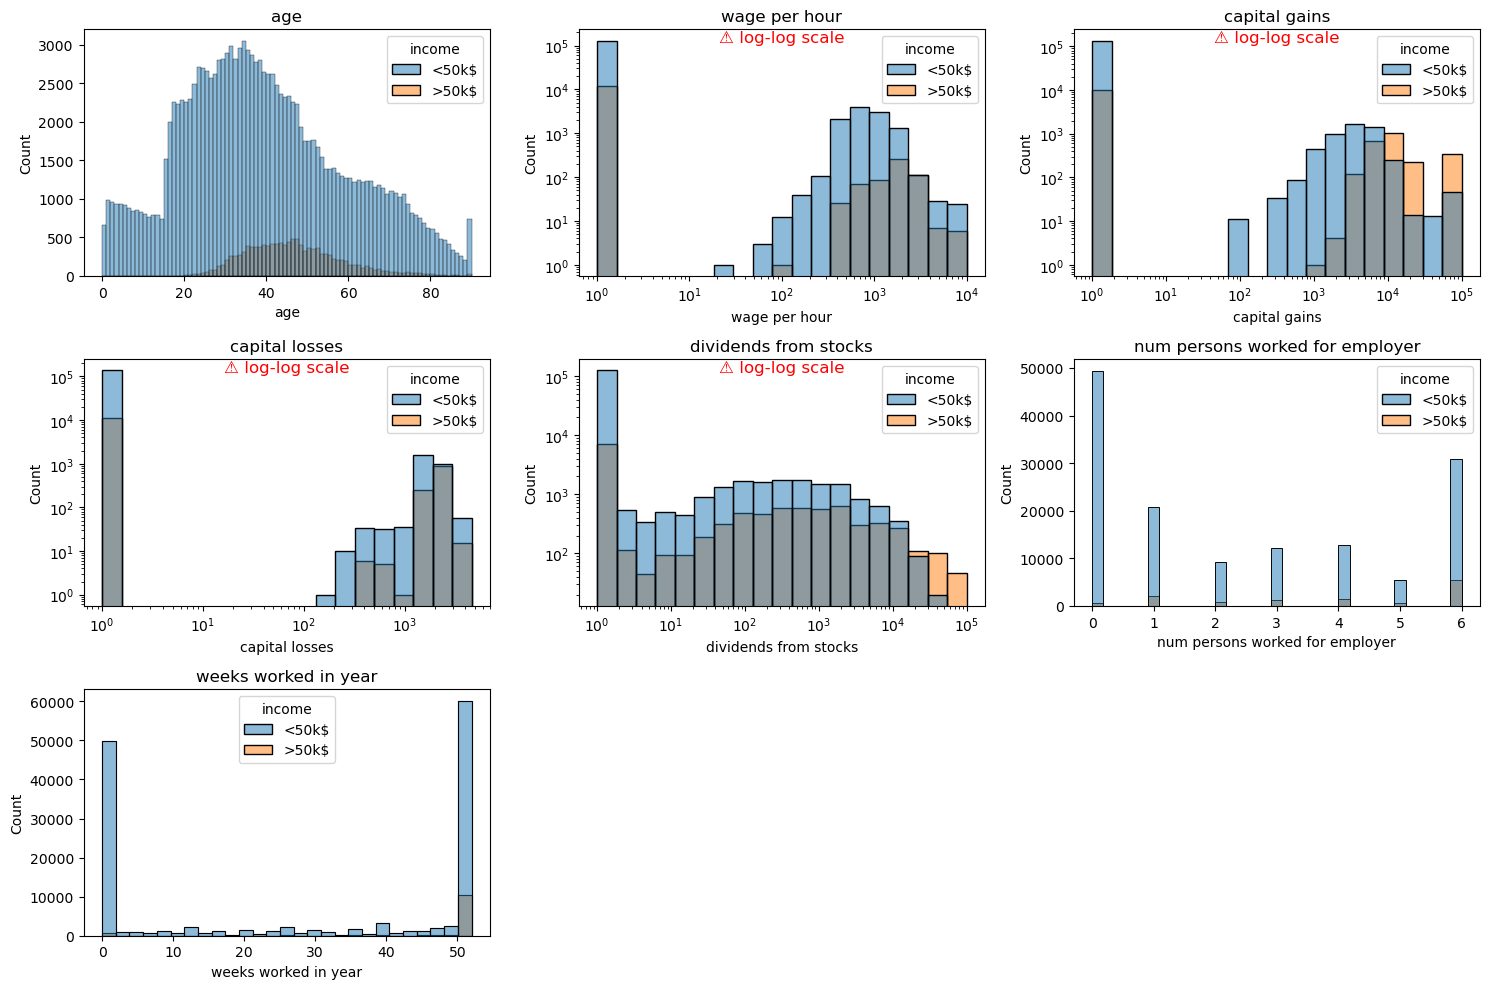

In [31]:
plt.figure(figsize=(15, 10))
log_scale_vars = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']
df_plot = train_data[select_continuous_features].copy()
df_plot['income'] = train_data[TARGET].map({0: '<50k$', 1: '>50k$'})
for i, feature in enumerate(select_continuous_features):
    plt.subplot(3, 3, i+1)
    log_scale = False
    if feature in log_scale_vars:
        df_plot[feature] = df_plot[feature] + 1
        log_scale = True 
        plt.yscale('log')   
        plt.text(0.5, 0.95, '⚠ log-log scale', fontsize=12, ha='center', transform=plt.gca().transAxes,color='red' )
    sns.histplot(df_plot, x=feature, hue="income", kde=False, stat="count", log_scale=log_scale,multiple="layer",)

    plt.title(feature)
plt.tight_layout()



We need to zoom in on the tail of the distributions of the continous variables `wage per hour`, `capital gains`, `capital losses`, and `dividends from stocks`.

In [32]:
## Backup the log-scale variables
log_scale_vars = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']
np.savetxt('data/log_scale_vars.txt', log_scale_vars, fmt='%s')

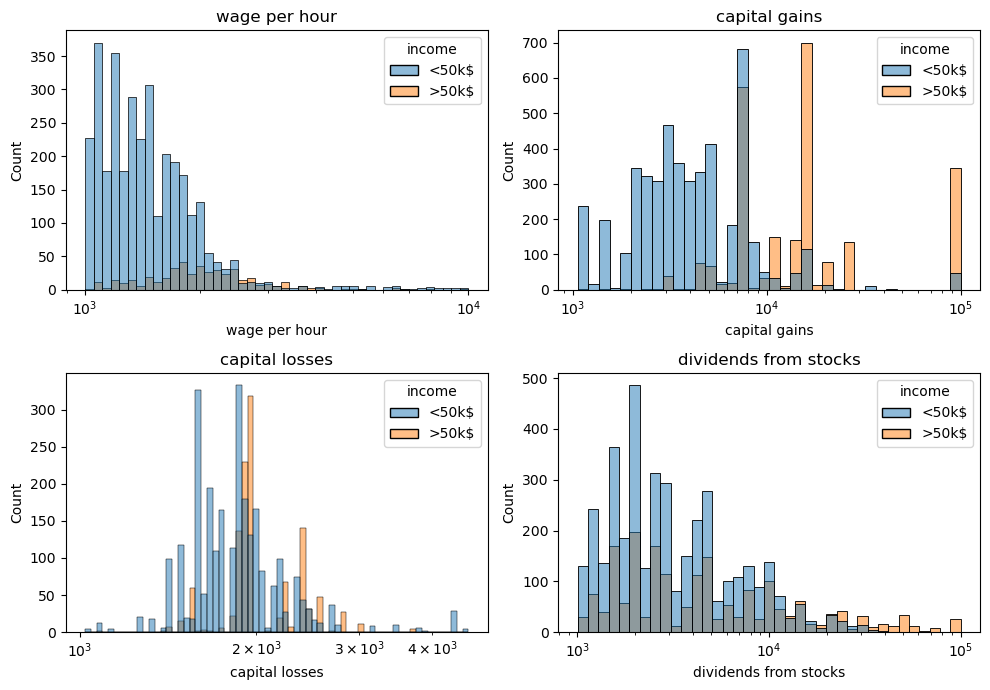

In [33]:
plt.figure(figsize=(10, 7))
df_plot = train_data[select_continuous_features].copy()
df_plot['income'] = train_data[TARGET].map({0: '<50k$', 1: '>50k$'})

for i, feature in enumerate(log_scale_vars):
    plt.subplot(2,2, i+1)
    sns.histplot(df_plot.loc[df_plot[feature]>1000], x=feature, hue="income", kde=False, stat="count", log_scale=True,multiple="layer",)
    plt.title(feature)
plt.tight_layout()

In [34]:
for feature in select_continuous_features:
    median_low_income = train_data.loc[~high_income_selector, feature].median()
    median_high_income = train_data.loc[high_income_selector, feature].median()
    print(f"Median {feature} for low income: {median_low_income:.2f} and high income: {median_high_income:.2f}")

Median age for low income: 37.00 and high income: 45.00
Median wage per hour for low income: 0.00 and high income: 0.00
Median capital gains for low income: 0.00 and high income: 0.00
Median capital losses for low income: 0.00 and high income: 0.00
Median dividends from stocks for low income: 0.00 and high income: 0.00
Median num persons worked for employer for low income: 2.00 and high income: 4.00
Median weeks worked in year for low income: 40.00 and high income: 52.00


The tail of the distributions of the continous variables `wage per hour`, `capital gains`, `capital losses`, and `dividends from stocks` is richer for high income individuals whereas the majority of those variable's values are 0 (hence the median). In order to account for the variability in the tail of the distribution, we will use a log scale for these variables.

Apart from this four "log"-variables, here is a few exra notes on the other variables:

- `age`: The distribution of age is right-shifted for high income individuals as compared to low income individuals. 
- `weeks worked in year`: The distribution of weeks worked in year is right-shifted for high income individuals as compared to low income individuals. The distribution is bimodal for both class of income.
- `num persons worked for employer`: The distribution of num persons worked for employer is right-shifted for high income individuals as compared to low income individuals. The distribution is bimodal for low income individuals.

Except for `age` (although slightly right-skewed), the distributions of the continous variables are not normal.

### Correlation between continous variables

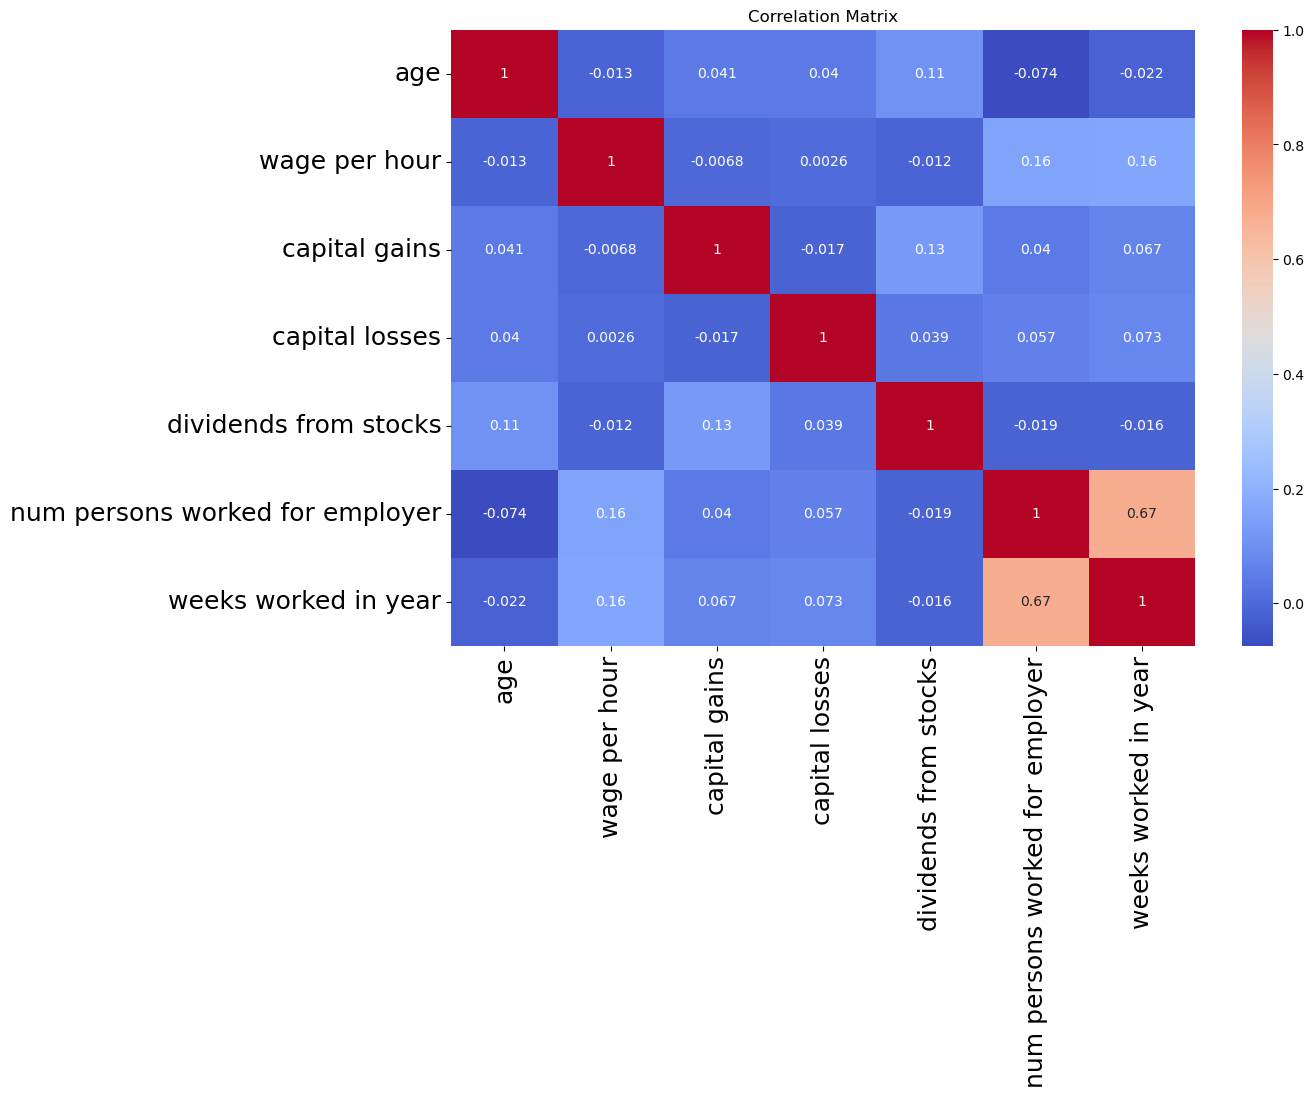

In [35]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(train_data[select_continuous_features].corr(), annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=18)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=18)
plt.title('Correlation Matrix')
plt.show()


`weeks worked in year` and `num persons worked for employer` are significantly correlated, a correlation of 0.67 is observed.  
If any of these variables is used in a model, we can consider removing the other. The models with and without the second variable can be compared to see if the second variable adds any value to the model.

Regarding the other variables, no significant correlation is observed.

### Mutual information between continous variables and target variable

A nice metric to quantify how much information knowing a variable gives about the target variable is the mutual information. The mutual information is usually computed between two discrete variables. However, it can be computed between a continous variable and a discrete variable by discretizing the continous variable.

The mutual information is sometimes dificult to interpret as it is not bounded but there exists a normalized version of the mutual information called the normalized mutual information. The normalized mutual information is bounded between 0 and 1.

**Note**: Bining the continous variables is a way to discretize them. Given the observations above, we will use the log values for the variables `wage per hour`, `capital gains`, `capital losses`, and `dividends from stocks` and the original values for the other continous variables.

NMI(capital gains)= 0.0978
NMI(dividends from stocks)= 0.0515
NMI(weeks worked in year)= 0.0370
NMI(capital losses)= 0.0277
NMI(num persons worked for employer)= 0.0232
NMI(age)= 0.0208
NMI(wage per hour)= 0.0108


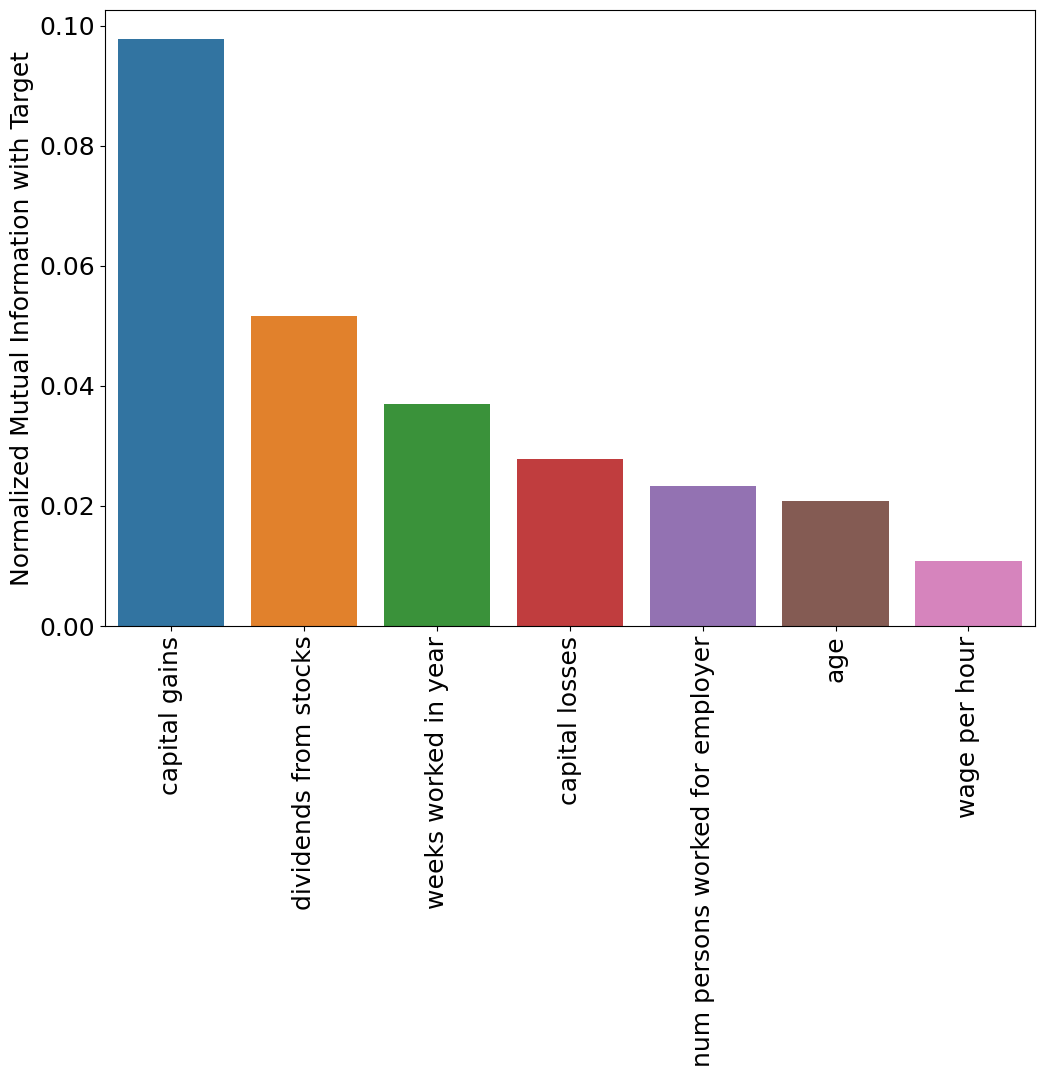

In [36]:
N_BINS = 15
df_MI = train_data[select_continuous_features].copy()
for feature in select_continuous_features:
    if feature in log_scale_vars:
        df_MI[feature] = np.log(df_MI[feature] + 1)
    df_MI[feature] = pd.cut(df_MI[feature], bins=N_BINS, labels=False).astype("category")

def compute_and_plot_NMI(data, target_values,figsize=(12, 8)):
    feature_names = data.columns
    nmi = pd.Series([normalized_mutual_info_score(data[feature], target_values) for feature in feature_names], index=feature_names).sort_values(ascending=False)
    fig=plt.figure(figsize=figsize)
    sns.barplot(x=nmi.index, y=nmi)
    plt.ylabel('Normalized Mutual Information with Target',fontsize=18)
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    return fig, nmi
    plt.xticks(rotation=90)
    return fig, nmi
         
_, nmi_continuous = compute_and_plot_NMI(df_MI, train_data[TARGET].values)
for feature in nmi_continuous.index:
    print(f"NMI({feature})= {nmi_continuous[feature]:.4f}")


As expected, none of the variable has a high normalized mutual information with the target variable. The highest normalized mutual information is ~0.1 for the variable `capital gains`. Those values are order features by the information they give about the target variable and they should also be compared with the values of the mutual information between the categorical variables and the target variable.

## Dealing with categorical variables


In [37]:
print("Number of nominal variables:", len(select_nominal_features))

Number of nominal variables: 33


### Not in universe features

A lot of the categorical variables have a category called "Not in universe" or "?". It is important to inspect the fraction of the dataset they represent in order to decide whether to keep them or not.


> you have been tasked with identifying characteristics that are associated with a person making more or less than $50,000 per year

The task is to identify important characteristics more than predicting the income category. Therefore, it is important to keep the variables that meaningfull at the scale of the complete dataset. Therefore, we will remove the variables with a high percentage of the class `Not in universe` higher than ~50%.

In [38]:
count_has_unknown_classes = 0
feature_to_remove = []
for feature in select_nominal_features:
    unique_value_counts = train_data[feature].value_counts()
    unique_value_counts.rename(index={key:f"{str(key).strip()}" for key in unique_value_counts.index}, inplace=True)
    unknown_count = 0
    if "Not in universe" in unique_value_counts.index:
        unknown_count+=unique_value_counts['Not in universe']
    if "?" in unique_value_counts.index:
        unknown_count+=unique_value_counts['?']
    if unknown_count:
        count_has_unknown_classes += 1
        keep = "keep"
        unknown_percentage = 100*unknown_count/len(train_data)
        if unknown_percentage > 50:
            feature_to_remove.append(feature)
            keep = "remove"
        print(f"Feature {feature} has {100*unknown_count/len(train_data):.1f}% samples with unknown class ➔ {keep}")
    
print(f"Total {count_has_unknown_classes} features have unknown classes")
print(f"Remove {len(feature_to_remove)} features with more than 50% unknown classes ({feature_to_remove})")


Feature class of worker has 35.4% samples with unknown class ➔ keep
Feature enroll in edu inst last wk has 93.0% samples with unknown class ➔ remove
Feature major occupation code has 35.7% samples with unknown class ➔ keep
Feature member of a labor union has 87.5% samples with unknown class ➔ remove
Feature reason for unemployment has 96.1% samples with unknown class ➔ remove
Feature region of previous residence has 89.9% samples with unknown class ➔ remove
Feature state of previous residence has 90.4% samples with unknown class ➔ remove
Feature migration code-change in msa has 49.2% samples with unknown class ➔ keep
Feature migration code-change in reg has 49.2% samples with unknown class ➔ keep
Feature migration code-move within reg has 49.2% samples with unknown class ➔ keep
Feature migration prev res in sunbelt has 89.9% samples with unknown class ➔ remove
Feature family members under 18 has 88.3% samples with unknown class ➔ remove
Feature country of birth father has 4.2% samples 

In [39]:
select_nominal_features = [x for x in select_nominal_features if x not in ['enroll in edu inst last wk', 'member of a labor union', 'reason for unemployment', 'region of previous residence','state of previous residence', "family members under 18",'fill inc questionnaire for veteran\'s admin']]
print(f"Number of nominal features after removing: {len(select_nominal_features)}")
np.savetxt('data/nominal_features.txt', select_nominal_features,  fmt="%s")

Number of nominal features after removing: 26



We have observed that with an imbalanced target variable, it is difficult to distinguish when high income fraction increases as compared to the low income. In this section, there are 33 categorical variables, so we need to develop a metric that quickly catches the eye when a class is enriched with high-income individuals.

Here is the fraction of high income individuals for each class of the categorical variables:


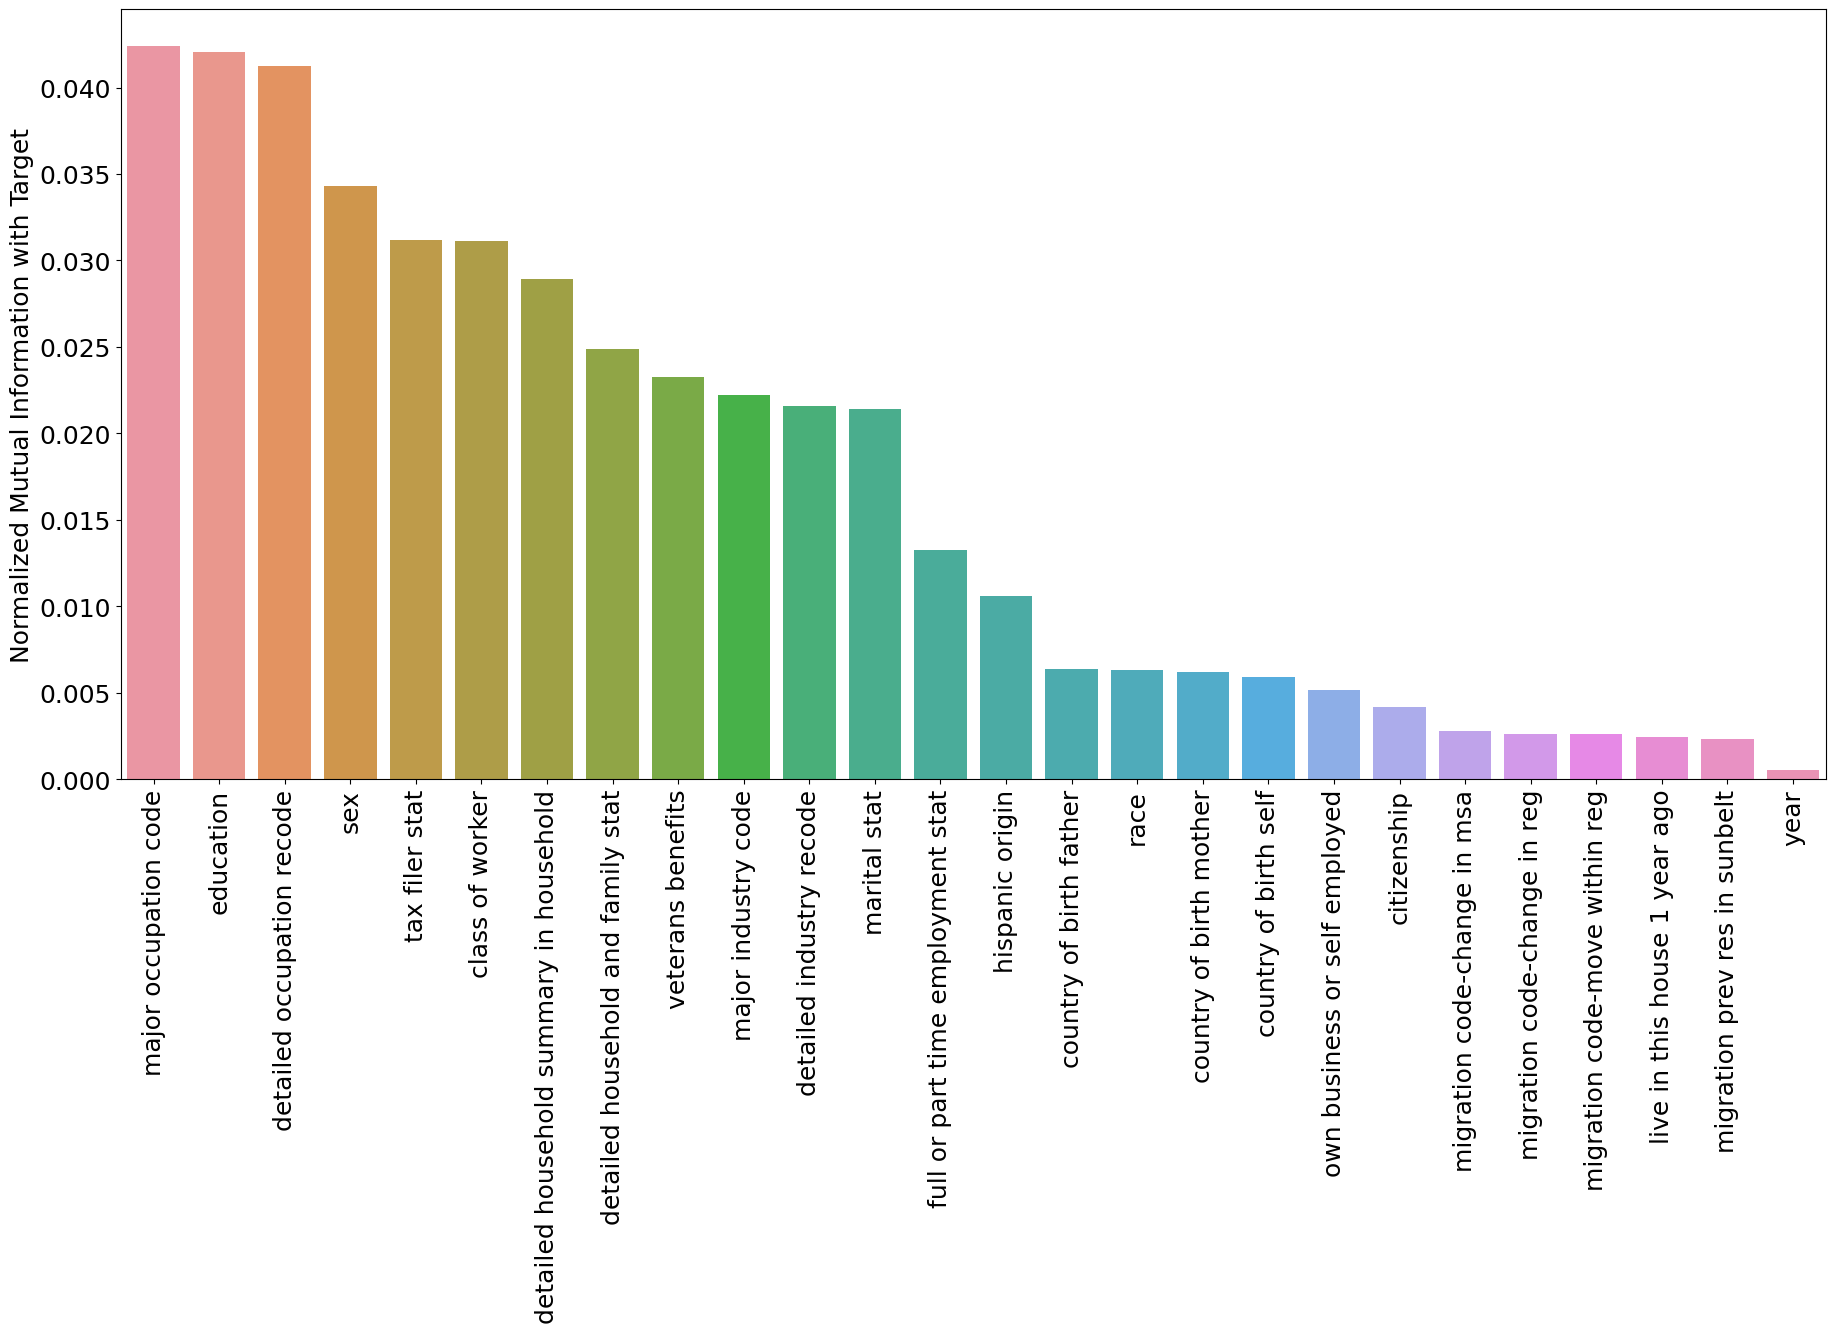

In [40]:
_,nominal_nmis = compute_and_plot_NMI(train_data[select_nominal_features], train_data[TARGET].values,figsize=(22, 10))

The mutual information is lower than for the three best continous variables which is understandable as the categorical variables have less values than the continous variables.

The mutual information tells us how much information a variable taken individually gives about the target variable. It does not tell us how much information a variable gives when combined with other variables. For this we will rely on the predictive power of the variable in a model. For the moment, we will keep all the categorical variables remaining as it is likely that some variables will provide information when combined with other variables.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'capital gains'),
  Text(1, 0, 'dividends from stocks'),
  Text(2, 0, 'major occupation code'),
  Text(3, 0, 'education'),
  Text(4, 0, 'detailed occupation recode'),
  Text(5, 0, 'weeks worked in year'),
  Text(6, 0, 'sex'),
  Text(7, 0, 'tax filer stat'),
  Text(8, 0, 'class of worker'),
  Text(9, 0, 'detailed household summary in household'),
  Text(10, 0, 'capital losses'),
  Text(11, 0, 'detailed household and family stat'),
  Text(12, 0, 'veterans benefits'),
  Text(13, 0, 'num persons worked for employer'),
  Text(14, 0, 'major industry code'),
  Text(15, 0, 'detailed industry recode'),
  Text(16, 0, 'marital stat'),
  Text(17, 0, 'age'),
  Text(18, 0, 'full or part time employment stat'),
  Text(19, 0, 'wage per hour'),
  Text(20, 0, 'hispanic origin'),
  Text(21, 0, 'country of birth father'),
  Text(22, 0, 'race'),


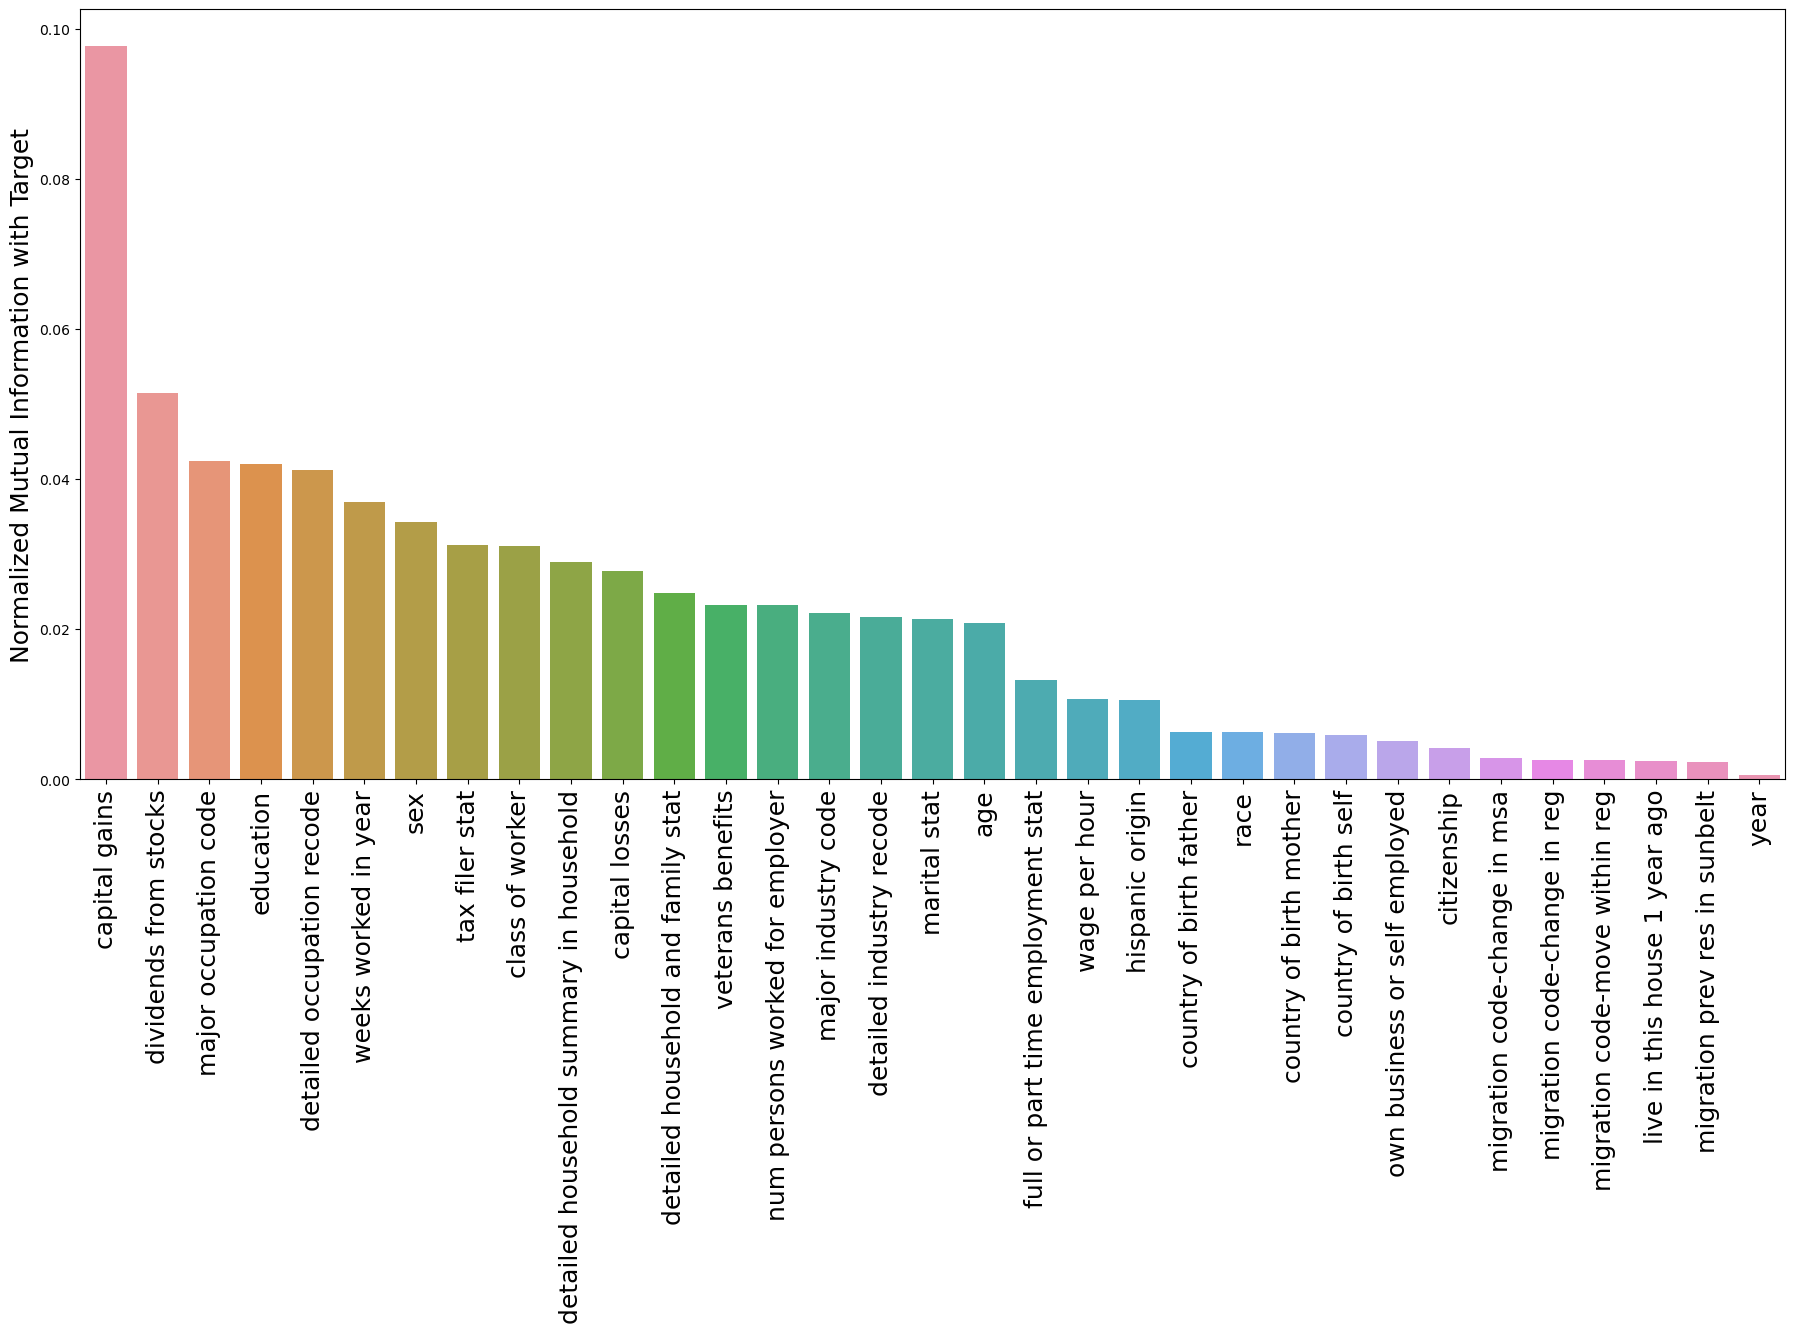

In [54]:
# Same as above but also include continuous variables
nmi_all = pd.concat([nmi_continuous, nominal_nmis], axis=0).sort_values(ascending=False)
plt.figure(figsize=(22, 10))
sns.barplot(x=nmi_all.index, y=nmi_all)
plt.ylabel('Normalized Mutual Information with Target',fontsize=18)
plt.xticks(rotation=90, fontsize=18)

### Cross-mutual information between categorical variables

Analaogous to the cross-correlation between continous variables, we can compute the cross-mutual information between categorical variables. The cross-mutual information is a measure of how much information knowing a variable gives about another variable.



In [47]:
np.concatenate([select_nominal_features ,select_continuous_features])

array(['class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'marital stat',
       'major industry code', 'major occupation code', 'race',
       'hispanic origin', 'sex', 'full or part time employment stat',
       'tax filer stat', 'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'own business or self employed', 'veterans benefits', 'year',
       'age', 'wage per hour', 'capital gains', 'capital losses',
       'dividends from stocks', 'num persons worked for employer',
       'weeks worked in year'], dtype=object)

In [49]:
df_cross_mutual_info = train_data[np.concatenate([select_nominal_features ,select_continuous_features])].copy()
cross_mutual_info_matrix = np.zeros((len(df_cross_mutual_info.columns), len(df_cross_mutual_info.columns)))

In [50]:
REFRESH_MATRIX = False # Turn to True to refresh the matrix, takes ~7min on a M1 macbook air. If False, the matrix is loaded from cache.

if REFRESH_MATRIX:
    tot_iter = len(df_cross_mutual_info.columns)**2
    for i, feature_i in enumerate(df_cross_mutual_info.columns):
        for j, feature_j in enumerate(df_cross_mutual_info.columns):
            cross_mutual_info_matrix[i, j] = normalized_mutual_info_score(df_cross_mutual_info[feature_i], df_cross_mutual_info[feature_j])
            count = len(df_cross_mutual_info.columns)*i +j
            print(f"count={count}/{tot_iter} {count/tot_iter*100:.2f}% done", end="\r")
    cross_mutual_info_matrix = pd.DataFrame(cross_mutual_info_matrix, index=df_cross_mutual_info.columns, columns=df_cross_mutual_info.columns)
    os.makedirs("cache", exist_ok=True)
    cross_mutual_info_matrix.to_csv("cache/cross_mutual_info_matrix.csv")
else:
    cross_mutual_info_matrix = pd.read_csv("cache/cross_mutual_info_matrix.csv", index_col=0)

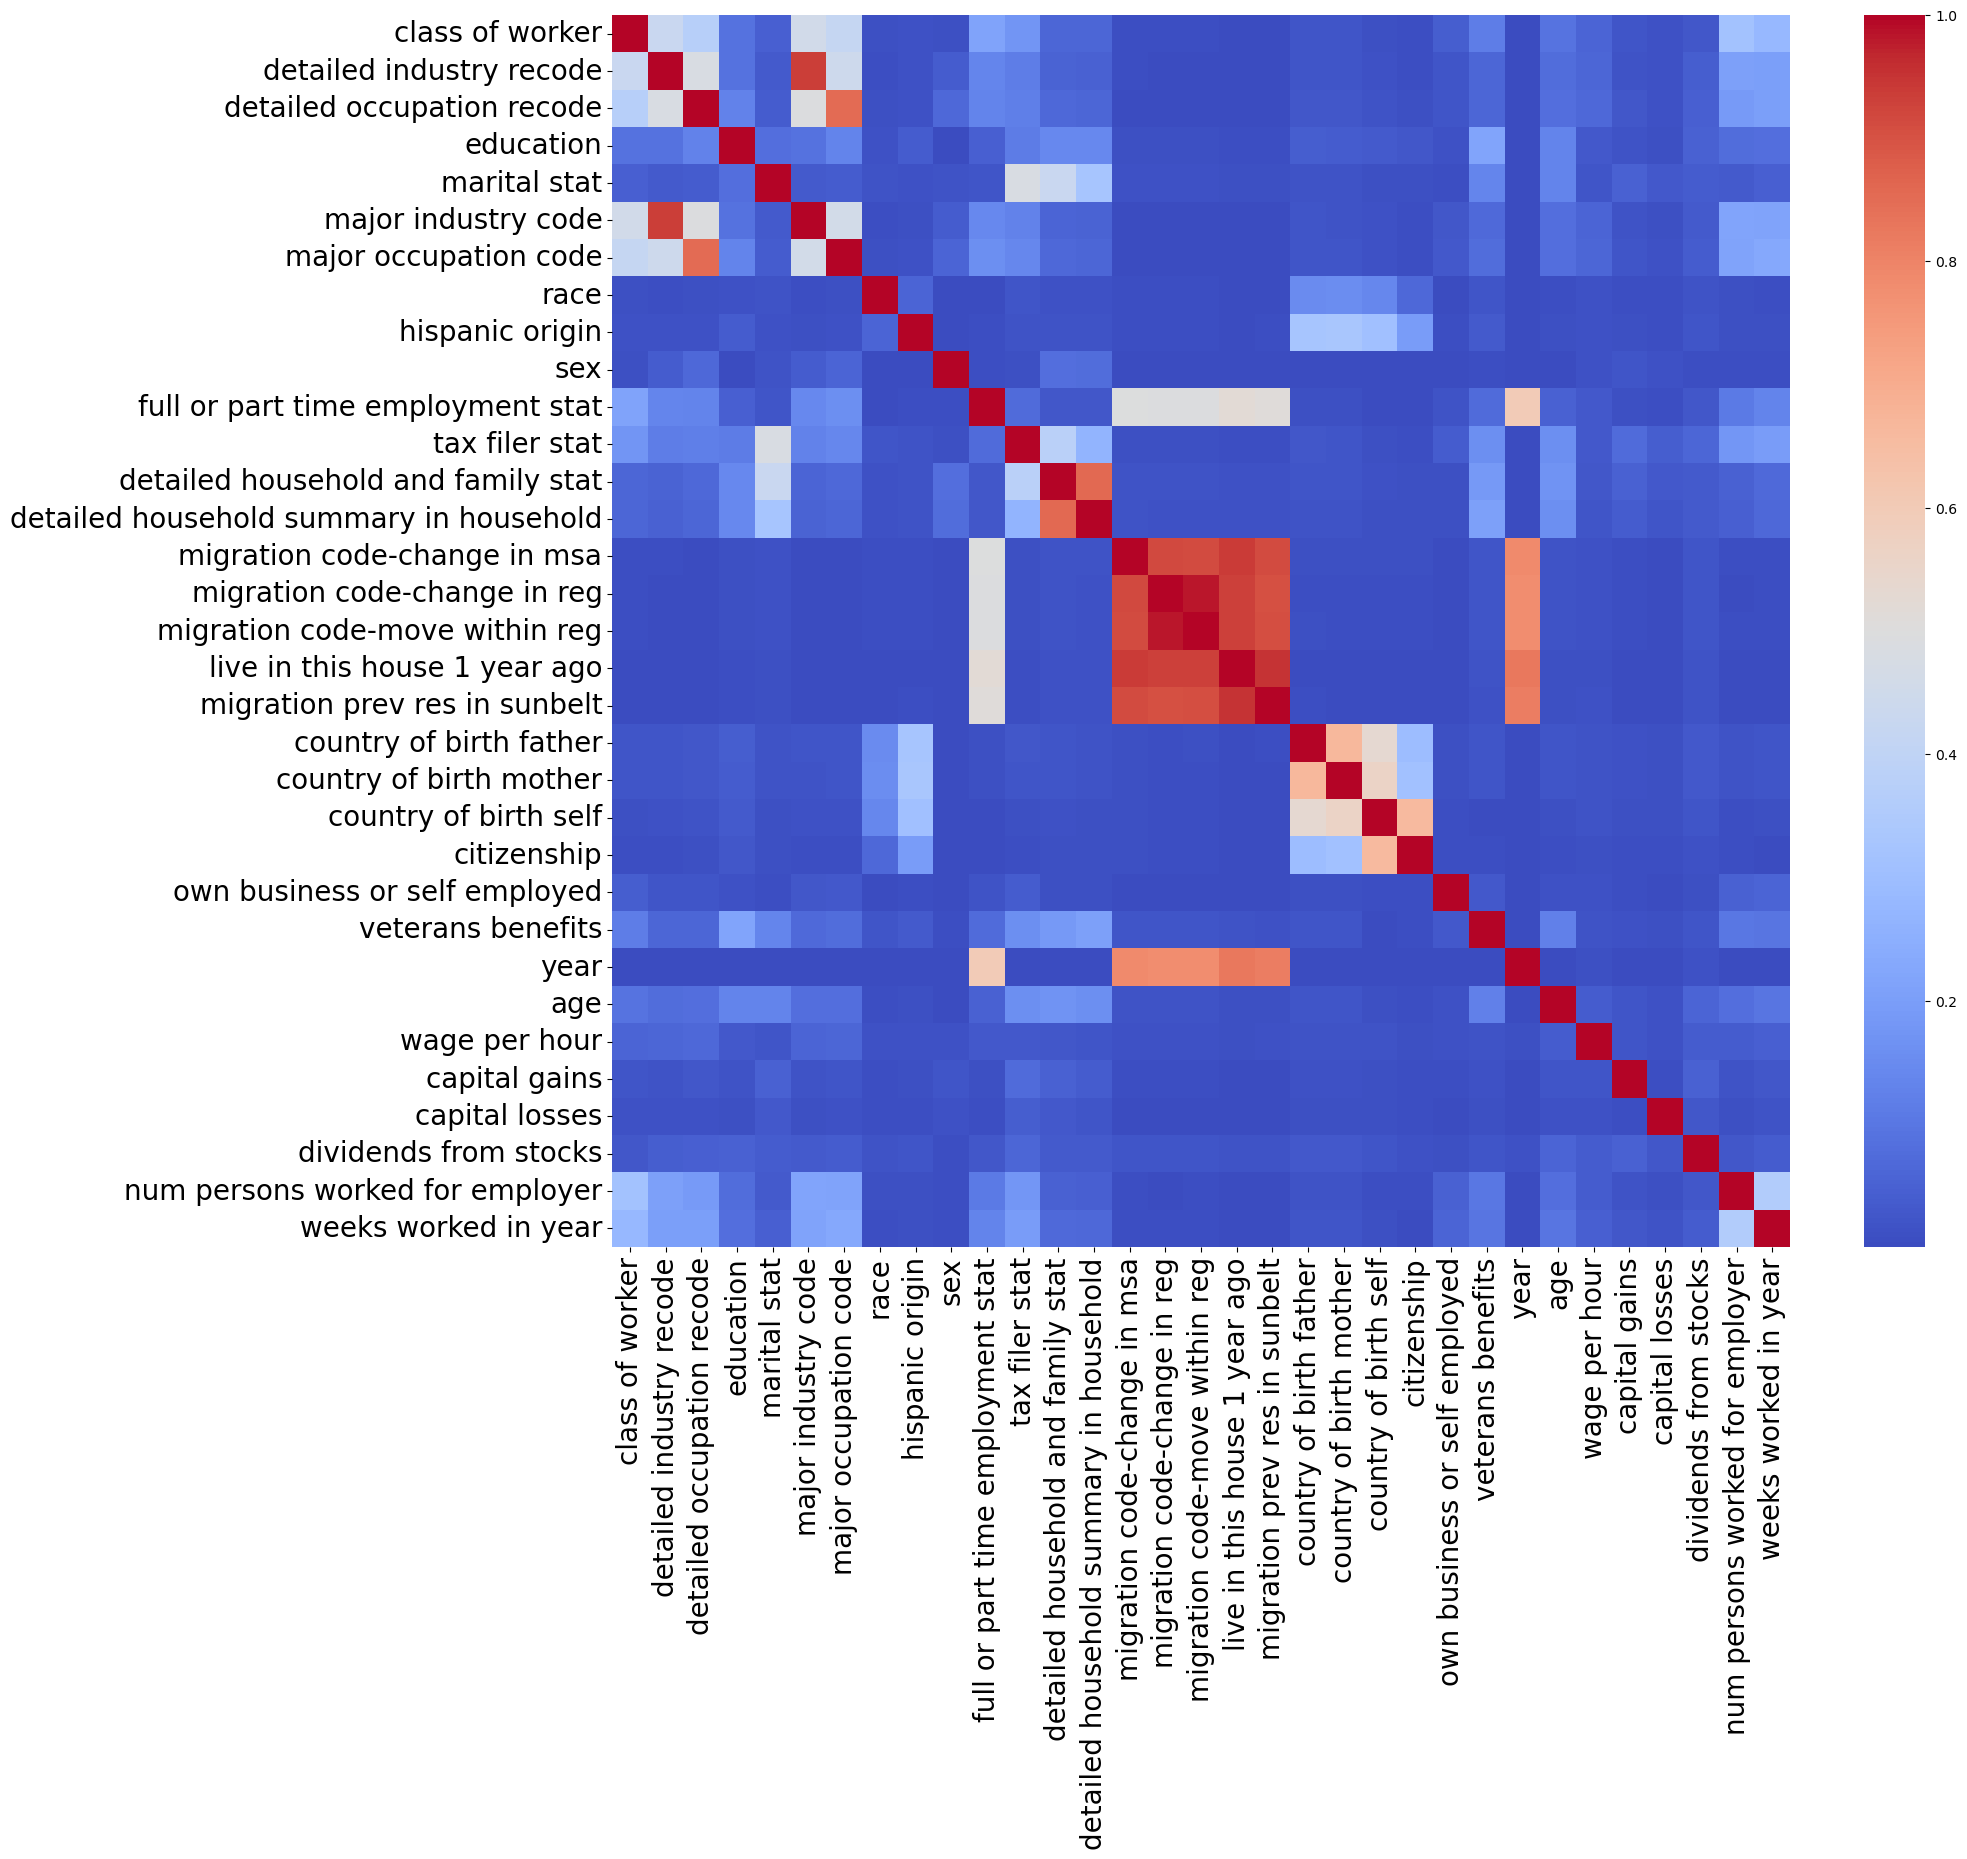

In [51]:
plt.figure(figsize=(19, 16))
heatmap = sns.heatmap(cross_mutual_info_matrix, xticklabels=cross_mutual_info_matrix.index, yticklabels=cross_mutual_info_matrix.columns, annot=False, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20);
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20);


The mutual information matrix is relatively sparse. This means that the variables are not highly correlated. This is good news as it means that the variables are not redundant.

Only a few patches of correlated variables are observed. When two variables share a high mutual information(>0.85), it means that they give similar information about the target variable. Therefore, we can consider removing one of the two variables. To choose which variable to remove, we can rely on the mutual information with the target variable. The variable with the lowest mutual information with the target variable can be removed.

In [61]:
feature_to_remove = []
for feature1 in cross_mutual_info_matrix.columns:
    for feature2 in cross_mutual_info_matrix.columns:
        if feature1 == feature2:
            continue
        if cross_mutual_info_matrix.loc[feature1, feature2] > 0.85:
            # Remove the feature with the lowest NMI with the target
            which_one = feature1 if nmi_all[feature1] < nmi_all[feature2] else feature2
            feature_to_remove.append(which_one)

feature_to_remove = list(set(feature_to_remove))

print("Variable to remove: ")
for feature in feature_to_remove:
    print(f"  {feature}")

Variable to remove: 
  migration code-move within reg
  detailed industry recode
  migration prev res in sunbelt
  live in this house 1 year ago
  migration code-change in reg
  detailed household and family stat
  detailed occupation recode


In [62]:
select_nominal_features = [x for x in select_nominal_features if x not in feature_to_remove]
np.savetxt('data/nominal_features.txt', select_nominal_features,  fmt="%s")

## Overview of the data separability

Here we will have a quick look at the data separability. Since there are 40 features (even more when encoded), we will use a dimensionality reduction technique to visualize the data: the umap algorithm.

The umap algorithm is a dimensionality reduction technique that is particularly good at preserving the local structure of the data. It is particularly useful to visualize the separability of the data.
Sometinmes, umap does not manage to capture the separability of the data and a step of linear discriminant analysis (LDA) helps to guide it toward the separability of the data we are interested in.

Before runing the LDA and umap algorithm, we need to encode the categorical variables. We will use the dummy encoding technique to encode the categorical variables and the rescale the continous variables tht live on a different scale.

In [149]:
df_umap = train_data.loc[:, select_continuous_features].copy()

# Log scale the continuous variables that have a large range
for feature in log_scale_vars:
    df_umap[feature] = np.log(df_umap[feature] + 1)
# Normalize the continuous variables
df_umap = (df_umap - df_umap.min()) / (df_umap.max() - df_umap.min())

# Add target
df_umap[TARGET] = train_data[TARGET]

# Dummy encode the nominal variables
dummified_nominal = pd.get_dummies(train_data[select_nominal_features].astype(str), drop_first=True)
df_umap = pd.concat([df_umap, dummified_nominal], axis=1)

In [150]:

df_umap, _ = train_test_split(df_umap, test_size=0.8, stratify=df_umap[TARGET])
# Apply UMAP
umap_model = umap.UMAP(n_components=10, n_neighbors=5, min_dist=0.2, metric='euclidean')
umap_embedding = umap_model.fit_transform(df_umap.drop(TARGET, axis=1), y=df_umap[TARGET])



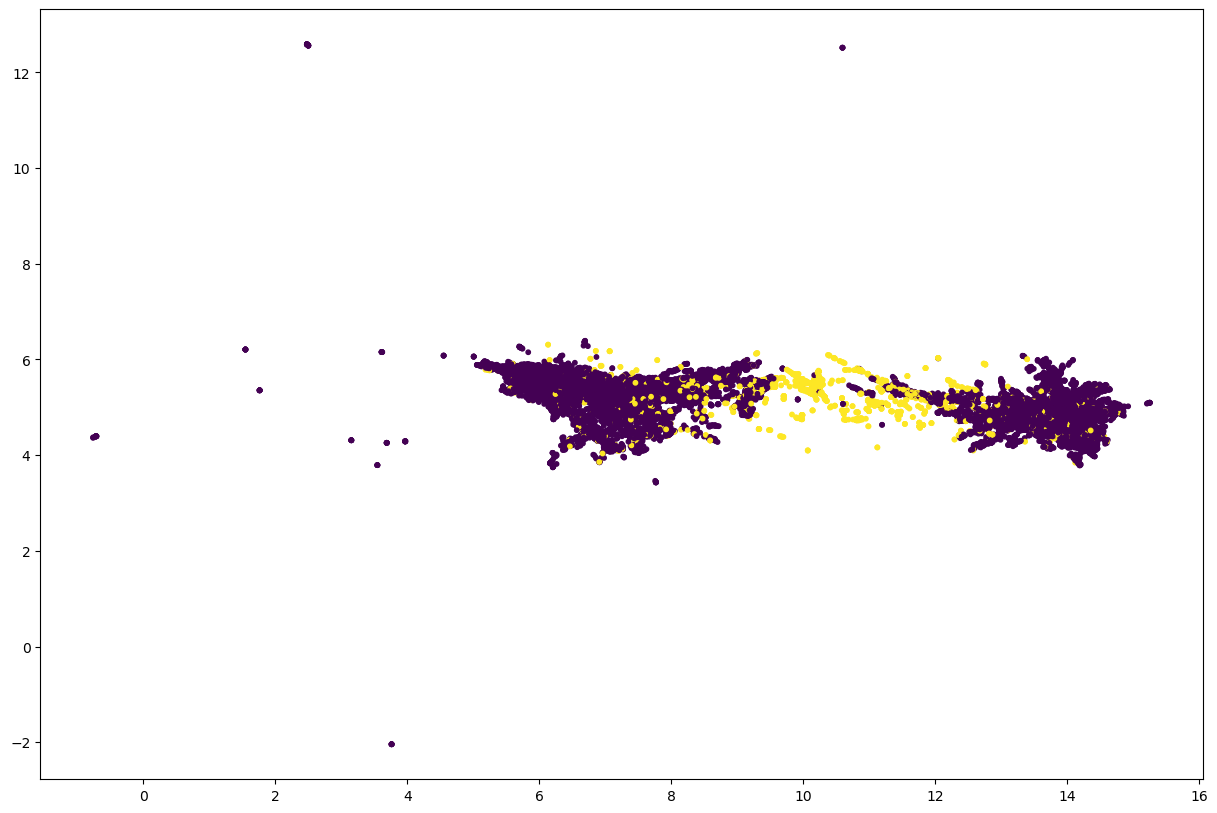

In [152]:
plt.figure(figsize=(15, 10))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=df_umap[TARGET], cmap='viridis', s=10) 

It is interesting to note that a significant fraction of the data is separable. This is a good news as it means that the data contains information that can be used to predict the target variable.